In [1]:
import delfi.distribution as dd
import delfi.generator as dg
import delfi.inference as infer
import delfi.summarystats as ds
import matplotlib.pyplot as plt

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

from tqdm import tqdm_notebook as tqdm

import numpy as np

from delfi.simulator.Gauss import Gauss

%run -i common.ipynb
#%matplotlib notebook


# FIGURE AND GRID
FIG_HEIGHT_MM = 50
FIG_WIDTH_MM = FIG_WIDTH_MM  # set in NIPS2017 notebook to a default value for all figures
FIG_N_ROWS = 2

fig_size = (FIG_WIDTH_MM / 25.4, FIG_N_ROWS * FIG_HEIGHT_MM / 25.4)
PATH_DROPBOX_FIGS = PATH_DROPBOX + 'figs/'

# PATHS
PANEL = PATH_DROPBOX_FIGS + 'dklterm'
PANEL_PDF = PANEL + '.pdf'

In [2]:
n_params = 10
n_rounds = 50
n_hiddens = 2
n_samples_per_round = 2000
epochs = 50
seed = None# 42000
m = Gauss(dim=1, seed=seed)

prior = dd.Gaussian(m=[0], S=[[25]], seed=seed)
s = ds.Identity()
g = dg.Default(model=m, prior=prior, summary=s)

_, x_obs = g.gen(1, verbose=False)

In [3]:
print(x_obs)

[[-6.4753541]]


In [4]:
# set up inference
#res = infer.CDELFI(g, obs=obs, n_components=2)

# Seed 42000 gives NaNs

res = infer.SNPE(g, obs=x_obs, n_hiddens=[n_hiddens], seed=seed, svi=True, convert_to_T=None)

minibatch = n_samples_per_round if n_samples_per_round < 100 else 100

regkeys = [ 'reg.mds{}'.format(i) for i in range(4) ]

log, trn_data = res.run(n_train=n_samples_per_round, epochs=epochs, n_rounds=n_rounds, minibatch=minibatch,
                        stop_on_nan=True,
                        monitor=['reg.quad_form', 'reg.diff_logdet_Sigma', 'reg.tr_invSigma2_Sigma1',
                                 'reg.logdetP'] + regkeys)

In [5]:
mdiffs = np.asarray([ np.concatenate([ l[k][-1].reshape(-1) for k in regkeys ]) for l in log[1:] ]).T

In [6]:
meanfunc = lambda x: x[-1] # np.mean(x)

dkl1s = np.asarray([ meanfunc(d['reg.diff_logdet_Sigma']) for d in log[1:] ])
dkl2s = np.asarray([ meanfunc(d['reg.tr_invSigma2_Sigma1']) for d in log[1:] ]) - n_params
dkl3s = np.asarray([ meanfunc(d['reg.quad_form']) for d in log[1:] ])

precs = np.asarray([ meanfunc(d['reg.logdetP']) for d in log[1:] ])

dkls = 0.5 * (dkl1s + dkl2s + dkl3s)

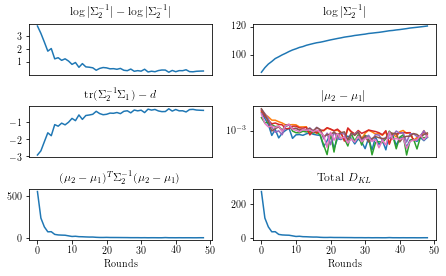

In [10]:
xlist = range(0, len(dkls))

fig, ((ax1, axprec), (ax2, axmd), (ax3, axtot)) = plt.subplots(3,2, sharex=True, figsize=fig_size)

axprec.set_title("$\log{|\Sigma_2^{-1}|}$")
#axprec.yaxis.tick_right()
axprec.xaxis.set_ticks_position('none') 
axprec.plot(xlist, precs)

axmd.set_title("$|\mu_2 - \mu_1|$")
axmd.xaxis.set_ticks_position('none') 
#axmd.yaxis.tick_right()
for md in mdiffs:
    axmd.semilogy(xlist, np.abs(md))

ax1.set_title("$\log{|\Sigma_2^{-1}|} - \log{|\Sigma_2^{-1}|}$")
ax1.xaxis.set_ticks_position('none') 
#ax1.yaxis.tick_right()
ax1.plot(xlist, dkl1s)

ax2.set_title("$\mathrm{tr} (\Sigma_2^{-1}\Sigma_1) - d$")
ax2.xaxis.set_ticks_position('none') 
#ax2.yaxis.tick_right()
ax2.plot(xlist, dkl2s)

ax3.set_title("$(\mu_2 - \mu_1)^T \Sigma_2^{-1}(\mu_2 - \mu_1)$")
#ax3.yaxis.tick_right()
ax3.set_xlabel("Rounds")
ax3.plot(xlist, dkl3s)

axtot.set_title("Total $D_{KL}$")
#axtot.yaxis.tick_right()
axtot.plot(xlist, dkls)
axtot.set_xlabel("Rounds")
plt.tight_layout()

plt.savefig(PANEL_PDF)
plt.show()

In [11]:
plt.savefig(PANEL_PDF)